In [123]:
import pandas as pd
import pandas_ta as ta
import numpy as np
import yfinance as yf
import vectorbt as vbt
import datetime as datetime

In [124]:
data = pd.DataFrame()
data = data.ta.ticker('AAPL', period='5y', interval='1d')

In [125]:
df = data.copy()
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2017-03-13,32.774146,32.911046,32.767065,32.856758,69686800,0.0,0.0
2017-03-14,32.880369,32.962981,32.771789,32.807198,61236400,0.0,0.0
2017-03-15,32.906343,33.222636,32.816647,33.154186,102767200,0.0,0.0
2017-03-16,33.215546,33.286359,33.106967,33.208466,76928000,0.0,0.0
2017-03-17,33.281646,33.281646,33.019642,33.043247,175540000,0.0,0.0
...,...,...,...,...,...,...,...
2022-03-07,163.360001,165.020004,159.039993,159.300003,96418800,0.0,0.0
2022-03-08,158.820007,162.880005,155.800003,157.440002,131148300,0.0,0.0
2022-03-09,161.479996,163.410004,159.410004,162.949997,91454900,0.0,0.0


In [126]:
custom_strategy = ta.Strategy(
    name = 'Custom STA',
    description = 'For Testing',
    ta = [
        {'kind':'ema', 'length':20},
        {'kind':'ema', 'length':50},
        {'kind':'ema', 'length':100},
        {'kind':'ema', 'length':200},
        {'kind':'rsi', 'length':14},
        {'kind':'macd'}
    ]
)

In [211]:
df = data.copy()
df.ta.strategy(custom_strategy)

In [212]:
def my_strategy(df):
    if (df.RSI_14 > 20) and (df.MACD_12_26_9 > 0) and (df.Close > df.EMA_200):
        return True
    else:
        return False

In [213]:
df['signal'] = df.apply(my_strategy, axis=1)
#df.loc[df.signal == True]


In [214]:
signal_vectorbt = df.ta.tsignals(df.signal, asbool=True, append=True, trade_offset=1) # trade_offset; backtest use 1, live use 0

In [215]:
port = vbt.Portfolio.from_signals(df.Open, #Close or Open but Open is faster
                                  direction='both',
                                  entries = signal_vectorbt.TS_Entries,
                                  exits = signal_vectorbt.TS_Exits,
                                  freq = 'D',
                                  init_cash = 100000,
                                  fees = 0.0025,
                                  slippage = 0.0025,
                                  sl_trail = 0.2)    # sl_stop, tp_stop, sl_trail
port.plot().show()

In [216]:
port.stats()

Start                         2017-03-13 00:00:00
End                           2022-03-11 00:00:00
Period                         1260 days 00:00:00
Start Value                              100000.0
End Value                           129402.889646
Total Return [%]                         29.40289
Benchmark Return [%]                   384.924889
Max Gross Exposure [%]                      100.0
Total Fees Paid                      15947.156567
Max Drawdown [%]                        43.664286
Max Drawdown Duration           461 days 00:00:00
Total Trades                                   30
Total Closed Trades                            29
Total Open Trades                               1
Open Trade PnL                        4368.259836
Win Rate [%]                            31.034483
Best Trade [%]                          44.822046
Worst Trade [%]                        -12.867554
Avg Winning Trade [%]                    16.26418
Avg Losing Trade [%]                    -5.146528


In [133]:
def rsi_func(df, days=14, lower=30, upper=70):
    chg = df['Close'].diff(1)
    
    gain = chg.mask(chg<0,0) # if value < 0 then 0
    loss = chg.mask(chg>0,0) # if value > 0 then 0
    avg_gain = gain.rolling(days).mean() # by default min_periods = window
    avg_loss = abs(loss.rolling(days).mean())
    rs = avg_gain/avg_loss
    rsi = 100 - (100/(1+rs))
    df['rsi'] = rsi
    
    # Find action zone
    df.loc[(df['rsi'] > upper), 'action'] = 'sell'
    df.loc[(df['rsi'] < lower), 'action'] = 'buy'
    df.loc[df['action'] == 'buy', 'marker_position'] = df['Low'] * 0.98
    df.loc[df['action'] == 'sell', 'marker_position'] = df['High'] * 1.02
    
    return df

C:\Users\gunsr\anaconda3\envs\investing\lib\site-packages\mplfinance\_arg_validators.py:35: UserWarning:




            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.




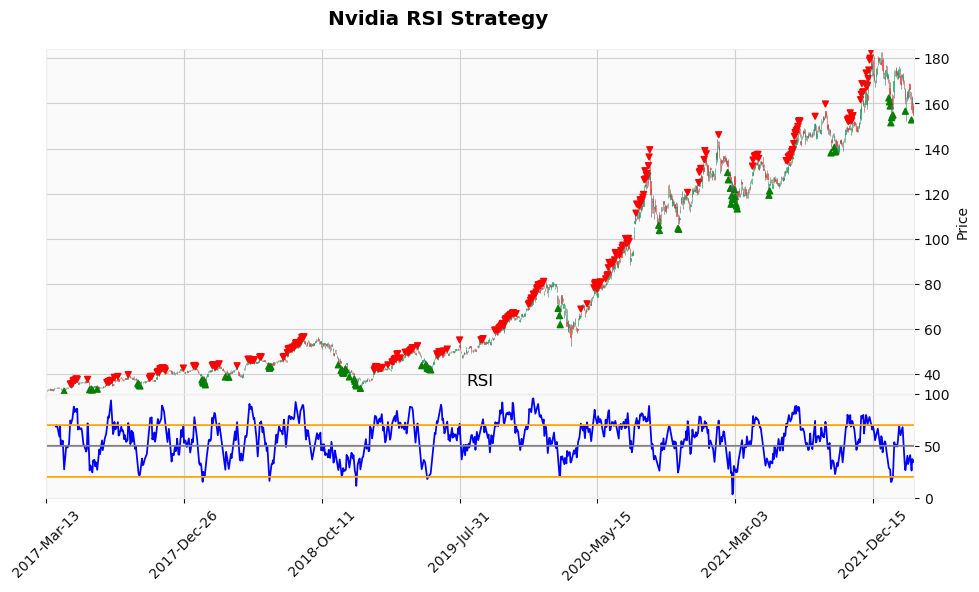

In [134]:
import mplfinance as mpf

def rsi_plot(df_plot, lower=20, mid=50, upper=70):
    df = rsi_func(df_plot)
    
    df['lower'] = lower
    df['upper'] = upper
    df['mid'] = mid
    rsi_ylim = (0,100)
    
    # for plot rsi
    mpf_rsi = mpf.make_addplot(df['rsi'], panel=1, color='blue', title='RSI', ylim=rsi_ylim)
    mpf_lower = mpf.make_addplot(df['lower'], panel=1, color='orange', ylim=rsi_ylim)
    mpf_upper = mpf.make_addplot(df['upper'], panel=1, color='orange', ylim=rsi_ylim)
    mpf_mid = mpf.make_addplot(df['mid'], panel=1, color='gray', ylim=rsi_ylim)
    
    # for marker
    markers = ['^' if x == 'buy' else 'v' for x in df['action']]
    color_marker = ['green' if x == 'buy' else 'red' for x in df['action']]
    plot_signal = mpf.make_addplot(df['marker_position'], type='scatter', marker=markers, color=color_marker)

    plots = [mpf_rsi, mpf_lower, mpf_mid, mpf_upper, plot_signal]
    
    return plots

df = data.copy()
rsi_to_plot = rsi_plot(df)

mpf.plot(df, type='candle', style='yahoo', addplot=rsi_to_plot, title="Nvidia RSI Strategy",
         figsize=(10,6), panel_ratios=(1,0.3),
         tight_layout=True, scale_padding={'top':5})